In [1]:
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import *
import vgg16
import pandas as pd
import numpy as np
from glob import glob
from keras.layers import Dense, Conv2D, BatchNormalization, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

%matplotlib inline

cwd = os.getcwd()
data_dir = os.path.join(os.path.dirname(cwd), 'data')

input_dir = os.path.join(os.path.dirname(cwd), 'data', 'imgs')
output_dir = os.path.join(os.path.dirname(cwd), 'data', 'crops')

batch_size=64
num_class = 447


Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [2]:
bbtrw = 600.0
bbtrh = 400.0

In [3]:
% cd $cwd

/home/ubuntu/courses/deeplearning1/nbs/whale_recognition


In [164]:
tr_ann = pd.read_csv('bbox_600_400_.csv')
#test_ann = pd.read_csv('test_bb_ann_600_400.csv')

In [165]:
tr_ann = tr_ann.rename(columns={'bboxx':'bx', 'bboxy':'by', 'width': 'bw', 'height': 'bh'})

In [166]:
tr_ann.head()

,Image,whaleID,bh,bw,image_width,image_height,bx,by,filename,x_1,y_1,x_2,y_2,bboxx_new,bboxy_new,width_new,height_new
0,w_7812.jpg,whale_48813,505.953358,505.953358,3072,2048,1411.343576,985.277591,w_7812.jpg,1668.211366,1370.097707,1647.792622,1108.737787,275.653042,192.437029,98.819015,98.819015
1,w_4598.jpg,whale_09913,478.725078,628.913338,3072,2048,1192.119312,1018.464137,w_4598.jpg,1639.625125,1212.873380,1353.762712,1265.962114,232.835803,198.918777,122.834636,93.500992
2,w_3828.jpg,whale_45062,459.951546,600.753039,3072,2048,1060.704585,826.035429,w_3828.jpg,1118.947159,908.634098,1345.595214,963.764706,207.168864,161.335045,117.334578,89.834286
3,w_8734.jpg,whale_74162,356.471430,337.585527,3072,2048,1496.707861,984.427725,w_8734.jpg,1690.671984,1223.082752,1682.504487,1069.942173,292.325754,192.271040,65.934673,69.623326
4,w_3251.jpg,whale_99558,538.248253,439.097259,3072,2048,1406.999818,644.481460,w_3251.jpg,1655.960120,1071.984048,1662.085743,878.005982,274.804652,125.875285,85.761183,105.126612


In [5]:
%cd $data_dir

/home/ubuntu/courses/deeplearning1/nbs/data


In [7]:
% mv w_7489.jpg $input_dir

In [11]:
% cd $input_dir

/home/ubuntu/courses/deeplearning1/nbs/data/imgs


In [5]:
test_ann = pd.read_csv('test_bb_ann_600_400.csv')

In [7]:
test_ann.head()

,Image,w,h,x,y
0,w_8037.jpg,96.706139,108.894379,232.960709,194.290939
1,w_4494.jpg,80.154961,81.834831,232.537827,99.211334
2,w_4673.jpg,114.023788,85.812225,237.209885,167.134125
3,w_8273.jpg,103.140839,73.877968,271.808258,130.176422
4,w_7611.jpg,109.106262,112.219261,321.994019,140.577164


In [10]:
% cd $input_dir

/home/ubuntu/courses/deeplearning1/nbs/data/imgs


# Test

In [11]:
def calc_bbox(r, bbtrw, bbtrh):    

    
    img = Image.open(r.Image)
    width, height = img.size
    smaller = min(width, height)
    #img = img.resize((smaller, smaller))
    width_ratio =  width / bbtrw
    height_ratio =  height /bbtrh 
    
    bx = r['x'] * width_ratio 
    by = r['y'] * height_ratio 
    bw = r['w'] * width_ratio
    bh = r['h'] * height_ratio
    #left = adj_x - (0.5 * adj_w)
    #upper = adj_y - (0.5* adj_h)
    #right = adj_x + (0.5*adj_w)
    #lower = adj_y + (0.5* adj_h)
    #print('adj_x', adj_x)
    #print('adj_w', adj_w)
    #print('adj_y', adj_y)
    #print('left', left)
    #print(lower)
    #crop = img.crop((adj_x, adj_y, adj_x + adj_w, adj_y + adj_h))
    #crop = crop.resize((224,224))
    #ew_name = crop_dir + '/' + r['jpg']
    #crop.save(new_name)
    return (r.Image , bx, by, bw, bh)

In [12]:
b_ann = test_ann.apply(lambda r: calc_bbox(r, bbtrw, bbtrh), axis=1)


In [13]:

b_ann = np.array([np.array(l) for l in b_ann
                  .values])


In [14]:

b_ann = pd.DataFrame(b_ann, columns=['Image','bx', 'by', 'bw', 'bh'])


In [15]:
b_ann[['bx', 'by', 'bw', 'bh']] = b_ann[['bx', 'by', 'bw', 'bh']].apply(pd.to_numeric)

In [16]:
b_ann.dtypes

Image     object
bx       float64
by       float64
bw       float64
bh       float64
dtype: object

In [17]:
def check_bbox(df, idx):
    r = df.iloc[idx, :]
    img = Image.open(r.Image)
    #img = img.resize((224,224))
    img_arr = np.array(img, dtype=np.uint8)

    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(img_arr)
    
    # Create a Rectangle patch
    
    rect = patches.Rectangle((r.bx,r.by ),
                             r.bw,
                             r.bh, 
                             linewidth=1,
                             edgecolor='r',
                             facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    
    plt.show()



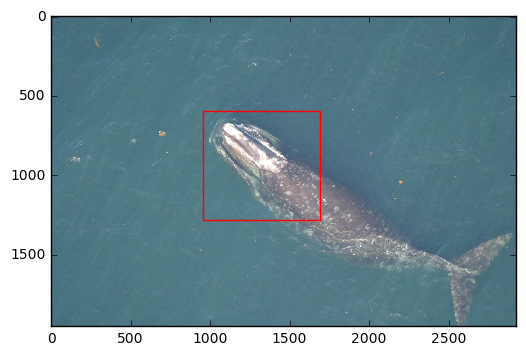

In [36]:
check_bbox(b_ann, np.random.randint(0,high=len(b_ann)))

In [38]:
b_ann.to_csv('test_full_size_bb_ann.csv')

In [173]:
def crop_im(r):    
    f_name = r['Image']
    img = Image.open(f_name)
    crop = img.crop((int(r.bx), int(r.by), int(r.bx + r.bw), int(r.by + r.bh)))
    new_name = os.path.join(output_dir, f_name)
    crop.save(new_name)


In [143]:
i = 0
for r in b_ann.iterrows():
    if i % 100 == 0: print(i)
    i+=1
    crop_im(r[1])

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900


# Train

In [144]:
tr_ann.head()

,Image,whaleID,height,width,image_width,image_height,bboxx,bboxy,filename,x_1,y_1,x_2,y_2,bboxx_new,bboxy_new,width_new,height_new
0,w_7812.jpg,whale_48813,505.953358,505.953358,3072,2048,1411.343576,985.277591,w_7812.jpg,1668.211366,1370.097707,1647.792622,1108.737787,275.653042,192.437029,98.819015,98.819015
1,w_4598.jpg,whale_09913,478.725078,628.913338,3072,2048,1192.119312,1018.464137,w_4598.jpg,1639.625125,1212.873380,1353.762712,1265.962114,232.835803,198.918777,122.834636,93.500992
2,w_3828.jpg,whale_45062,459.951546,600.753039,3072,2048,1060.704585,826.035429,w_3828.jpg,1118.947159,908.634098,1345.595214,963.764706,207.168864,161.335045,117.334578,89.834286
3,w_8734.jpg,whale_74162,356.471430,337.585527,3072,2048,1496.707861,984.427725,w_8734.jpg,1690.671984,1223.082752,1682.504487,1069.942173,292.325754,192.271040,65.934673,69.623326
4,w_3251.jpg,whale_99558,538.248253,439.097259,3072,2048,1406.999818,644.481460,w_3251.jpg,1655.960120,1071.984048,1662.085743,878.005982,274.804652,125.875285,85.761183,105.126612


In [168]:
% cd $input_dir

/home/ubuntu/courses/deeplearning1/nbs/data/imgs


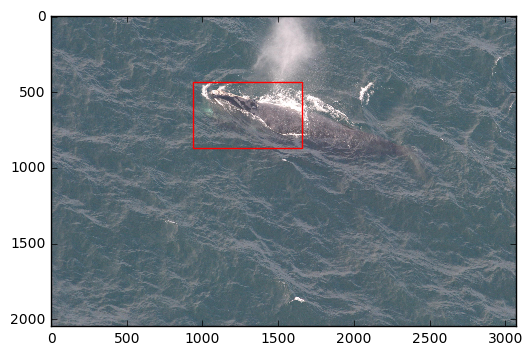

In [171]:
check_bbox(tr_ann,147)

In [174]:
i = 0
for r in tr_ann.iterrows():
    if i % 100 == 0: print(i)
    i+=1
    crop_im(r[1])

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500


# Check

In [175]:
% cd $output_dir

/home/ubuntu/courses/deeplearning1/nbs/data/crops


In [177]:
g = glob('*.jpg')

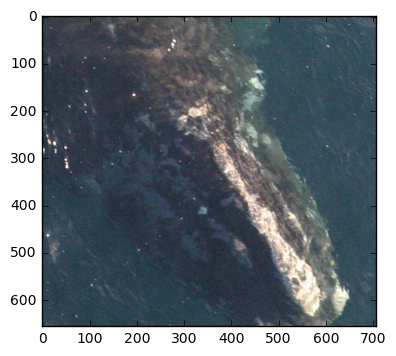

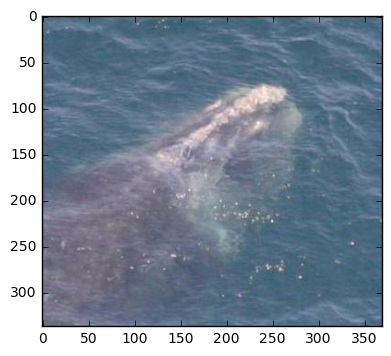

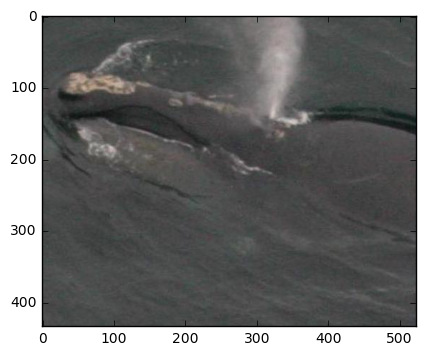

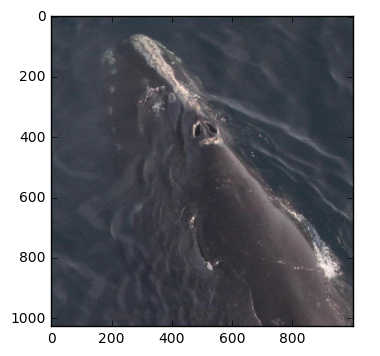

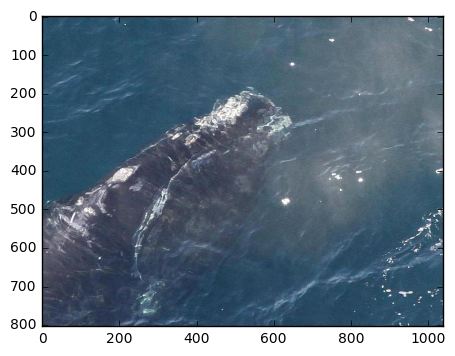

In [183]:
g = np.random.permutation(g)
for f in g[:5]:
    img = Image.open(f)
    img_arr = np.array(img, dtype=np.uint8)

    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(img_arr)
    plt.show()
    